# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer
Предыдущая часть: https://github.com/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb

-Work in progress (last updated:11/04/2023)-

B. Цель данного блокнота

Целью этого блокнота является использование SHAP на предобученной модели для понимания области наблюдения для каждого класса.

C. План реализации

1. Импортировать данные и модель
2. Реализовать расчет shap values
3. Реализовать построение графика для shap values и одного спектра

NOTES
1. Импортированы данные и модель
2. Получены данные shap values
3. Реализована функция визуализации

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [67]:
!git clone https://github.com/Lamblador/IR_expert_system.git

fatal: destination path 'IR_expert_system' already exists and is not an empty directory.


In [68]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install torchmetrics
!pip install shap
!pip install peakutils
clear_output()

In [69]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import shap
import torch.nn as nn
from peakutils.peak import indexes as index_utils


In [70]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

# Импорт табличных данных

In [71]:
#Считывание датасета
def read_dataset(dataset_name):
  '''
  Function for reading dataset into pandas Dataframe from /IR_expert_system/data/datasets/

  dataset_name - name of dataset's folder to read

  return pd.Dataframe with whole dataset

  parameters:
      name = ['dataset3']
          dataset3 - dataset made from reading most of jcam files, with padded y, interpolated x and peak layer. Saved in 10 pieces. 
  '''
  df_list = []
  # choose current directory
  curr_directory = os.getcwd()
  os.chdir(curr_directory)  # set to current directory
  files = glob.glob('/content/IR_expert_system/data/datasets/'+dataset_name+'/*.pkl')  # look for files without extension. Returns a list.
  # Try to read the file. If can't be read, skip it.
  #print(files)
  for i, file in tqdm(enumerate(files)):
      df = pd.read_pickle(file)
      df_list.append(df)
  #print(df_list)
  result = pd.concat(df_list)
  return result

dataset_df_test = read_dataset('dataset3')
dataset_df_test

10it [00:05,  1.91it/s]


,index,title,jcamp-dx,data type,origin,owner,molform,$nist source,spectrometer/data system,state,...,number of interferograms averaged per single channel spectrum,sample description,temperature,$spectra version,$uncertainty in y,pressure,x1,y1,y_peak,x_peak
cas registry no,,,,,,,,,,,,,,,,,,,,,
7496-45-9,7496-45-9,"Purine, 1-ethyl-",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,C7 H8 N4,COBLENTZ,PERKIN-ELMER 221 (GRATING),SOLID (0.8 mg / 650 mg KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13739997148513794, 0.13739997148513794, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[580, 640, 664, 726, 798, 834, 928, 966, 1022,..."
106-36-5,106-36-5,"Propanoic acid, propyl ester",4.24,INFRARED SPECTRUM,Sadtler Research Labs Under US-EPA Contract,NIST Standard Reference Data Program\nCollecti...,C 6 H 12 O 2,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.05554400011897087, 0.054496001452207565, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[542, 594, 618, 642, 674, 770, 814, 838, 882, ..."
5347-82-0,5347-82-0,DIMETHANE SULFONAMIDE,4.24,INFRARED SPECTRUM,"WYANDOTTE CHEMICALS CORP., WYANDOTTE, MICHIGAN...",COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,C2 H7 N O4 S2,COBLENTZ,"Not specified, most likely a prism, grating, o...",SOLID (MULL),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.21799999475479126, 0.21799999475479126, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[632, 662, 766, 866, 974, 1024, 1066, 1150, 13..."
112-17-4,112-17-4,1-Decanol acetate,4.24,INFRARED SPECTRUM,NIST Mass Spectrometry Data Center,NIST Standard Reference Data Program\nCollecti...,C 12 H 24 O 2,MSDC-IR,HP-GC/MS/IRD,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0001320000010309741, 0.0001320000010309741,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1042, 1234, 1370, 1462, 1762, 2866, 2934]"
4919-37-3,4919-37-3,"4-Hydroxy-3,5-dimethylbenzoic acid",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 9 H 10 O 3,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.01228999998420477, 0.01228999998420477, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[588, 656, 770, 934, 1104, 1146, 1198, 1266, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173-72-2,25173-72-2,"3-(3,4,5-Trimethoxyphenyl)propionic acid",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 12 H 16 O 5,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.010820000432431698, 0.010820000432431698, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[576, 778, 832, 930, 1016, 1044, 1118, 1186, 1..."
56946-83-9,56946-83-9,"2,5-Dichlorothiophene-3-sulphonyl chloride",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 4 H Cl 3 O 2 S 2,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13794000446796417, 0.13794000446796417, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[558, 598, 632, 830, 854, 1008, 1046, 1136, 11..."
823-09-6,823-09-6,"Pyrimidine, 2-(methylthio)-,",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,C5 H6 N2 S,COBLENTZ,PERKIN-ELMER 21 (GRATING),LIQUID (NEAT),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.2558000087738037, 0.2558000087738037, 0.255...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[610, 710, 748, 770, 796, 876, 964, 1012, 1062..."


In [72]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
labels_df = labels_df.set_index("CAS")

In [73]:
dataset_df_labeled = labels_df.join(dataset_df_test)

In [74]:
dataset_df_labeled1 = dataset_df_labeled[['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro',
       'title',
       'molform',
       'x', 'y', 'x1', 'y1', 'y_peak']]
dataset_df_labeled1

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,acyl halides,amides,nitro,title,molform,x,y,x1,y1,y_peak
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,"Benzene, 1-chloro-4-nitro-",C 6 H 4 Cl N O 2,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.025064226, 0.03873562, 0.039495144, 0.01962...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.026076922193169594, 0.02797572687268257, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0999999999999..."
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,p-Nitroaniline,C 6 H 6 N 2 O 2,"[551.688, 555.546, 559.404, 563.262, 567.12, 5...","[0.00505, 0.00536, 0.00556, 0.00599, 0.00634, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.005049999803304672, 0.005049999803304672, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,4-Nitrophenol,C 6 H 5 N O 3,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0002784, 0.0001464, 0.0001752, 0.0002928, 0...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0002783999952953309, 0.0002783999952953309,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,n-BUTYLTRIMETHYLSILANE,C7 H18 Si,"[203.607, 204.53778, 205.46855, 206.39932, 207...","[0.19099998, 0.19099998, 0.19099998, 0.1909999...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.08899998664855957, 0.08958601189397797, 0.0...","[0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, ..."
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,n-BUTYL CHLORODIMETHYL SILANE,C6 H15 Cl Si,"[625.2462, 625.5054, 625.7648, 626.0244, 626.2...","[0.208, 0.208, 0.20899999, 0.208, 0.208, 0.208...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.20800000429153442, 0.20800000429153442, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,"Benzenamine, N,N,4-trimethyl-",C 9 H 13 N,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.006145908, 0.006989464, 0.008676576, 0.0113...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.02355931419879198, 0.02319779060781002, 0.0...","[0.0, 0.0, 0.09999999999999998, 0.199999999999..."
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,"4,4-Dimethyl-2-pentyne",C 7 H 12,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0013761, 0.0011286, 0.0008943, 0.0006864, 0...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0013761000009253621, 0.0013761000009253621,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,"Ammonium chloride, 2-chloroethyltrimethyl-",C5 H13 Cl2 N,"[459.0, 460.0, 461.0, 462.0, 463.0, 464.0, 465...","[0.15679997, 0.15499997, 0.15319997, 0.1513000...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13220000267028809, 0.131299972534

In [75]:
spectra_x =dataset_df_labeled.iloc[:,-1]
spectra_x_t = torch.Tensor(spectra_x[0])
#spectra_x_t

# Создание класса Dataset

Вивлеты - преобразование для детектирования пиков.

In [76]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))     
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [77]:
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1)

In [78]:
#Создание объекта класса и разбиение на трейн,тест и вал
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1.dropna())
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [79]:
#Создание загрузчиков
# Number of classes
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

17

In [80]:
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

{'alkane': 0, 'methyl': 1, 'alkene': 2, 'alkyne': 3, 'alcohols': 4, 'amines': 5, 'nitriles': 6, 'aromatics': 7, 'alkyl halides': 8, 'esters': 9, 'ketones': 10, 'aldehydes': 11, 'carboxylic acids': 12, 'ether': 13, 'acyl halides': 14, 'amides': 15, 'nitro': 16}
{0: 'alkane', 1: 'methyl', 2: 'alkene', 3: 'alkyne', 4: 'alcohols', 5: 'amines', 6: 'nitriles', 7: 'aromatics', 8: 'alkyl halides', 9: 'esters', 10: 'ketones', 11: 'aldehydes', 12: 'carboxylic acids', 13: 'ether', 14: 'acyl halides', 15: 'amides', 16: 'nitro'}


In [81]:
# Расчёт весов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
print(wts4cls)

{'alkane': 0.6826801517067004, 'methyl': 0.6218289085545723, 'alkene': 0.13552465233881164, 'alkyne': 0.01955330804888327, 'alcohols': 0.21862621154656553, 'amines': 0.13080488832701223, 'nitriles': 0.038179519595448796, 'aromatics': 0.5845764854614413, 'alkyl halides': 0.2595027391487568, 'esters': 0.11639275179098188, 'ketones': 0.09405815423514538, 'aldehydes': 0.02064896755162242, 'carboxylic acids': 0.060345554150863887, 'ether': 0.250063211125158, 'acyl halides': 0.009608091024020228, 'amides': 0.07088074167720185, 'nitro': 0.05731142014327855}


In [82]:
#Веса классов
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6827, 0.6218, 0.1355, 0.0196, 0.2186, 0.1308, 0.0382, 0.5846, 0.2595,
        0.1164, 0.0941, 0.0206, 0.0603, 0.2501, 0.0096, 0.0709, 0.0573],
       dtype=torch.float64)


In [83]:
#Модифицирование весов для каждого класс:
level = 0.3
grain = 0.15
lg = level/grain
print(lg)
#Классы меньше grain процентов - увеличиваются в level/20 раза 
#Классы меньше 10 процентов - увеличиваются в level/10 раз 
#Классы меньше 5 процентов - увеличиваются в level/5 раз
#Классы меньше 1 процента - увеличиваются в level раз
weight_for_every_class_modified = []
for i in weight_for_every_class:
  if i <= grain/8: weight_for_every_class_modified.append(i/(32/lg))
  elif (i <= grain/4) and (i>grain/8): weight_for_every_class_modified.append(i/(16/lg))
  elif (i <= grain/2) and (i>grain/4): weight_for_every_class_modified.append(i/(8/lg))
  elif (i <= grain) and (i>grain/2): weight_for_every_class_modified.append(i/(4*lg))
  else: weight_for_every_class_modified.append(i)
weight_for_every_class_modified = torch.Tensor(weight_for_every_class_modified)
print(weight_for_every_class)
print(weight_for_every_class_modified)
print(weight_for_every_class_modified.size())

2.0
tensor([0.6827, 0.6218, 0.1355, 0.0196, 0.2186, 0.1308, 0.0382, 0.5846, 0.2595,
        0.1164, 0.0941, 0.0206, 0.0603, 0.2501, 0.0096, 0.0709, 0.0573],
       dtype=torch.float64)
tensor([6.8268e-01, 6.2183e-01, 1.6941e-02, 2.4442e-03, 2.1863e-01, 1.6351e-02,
        9.5449e-03, 5.8458e-01, 2.5950e-01, 1.4549e-02, 1.1757e-02, 2.5811e-03,
        1.5086e-02, 2.5006e-01, 6.0051e-04, 1.7720e-02, 1.4328e-02])
torch.Size([17])


In [84]:
#Расчёт веса образца на основе минимального веса любой функциональной группы 
labels1 = train_dataset.dataset.spectra_labels.to_numpy().copy()
labels1[labels1 == 0.0] = 100
#labels1

In [85]:
train_labels = torch.tensor(labels1)
weighted_labels  = train_labels*weight_for_every_class
weights_for_every_sample = []
for label_tensor in weighted_labels:
  weight = np.nanmin(label_tensor.numpy())
  weights_for_every_sample.append(weight)

weights_for_every_sample = torch.tensor(weights_for_every_sample)
print(weights_for_every_sample)

tensor([0.0573, 0.0573, 0.0573,  ..., 0.2595, 0.0573, 0.1308],
       dtype=torch.float64)


In [86]:
weights_train = weights_for_every_sample[:len(train_dataset)]

In [87]:
weights_train

tensor([0.0573, 0.0573, 0.0573,  ..., 0.0603, 0.2186, 0.2595],
       dtype=torch.float64)

In [88]:
#Проверка на положительные вероятности
for i in range(len(weights_train)):
    if weights_train[i] < 0:
        weights_train[i] = abs(weights_train[i])

In [89]:
weights_train[weights_train<0]

tensor([], dtype=torch.float64)

In [90]:
#Сумма весов должна быть равна единице. Вычисление суммы:
sum_weights = 0
for i in range(len(weights_train)):
 
  #print(weights_train[i])
  if weights_train[i] == torch.tensor(np.nan, dtype=torch.float64) : weights_train[i] = 1
  #print(weights_train[i])
  #print(sum_weights)
  sum_weights +=weights_train[i].numpy()
print(sum_weights)

1743.1378845343193


In [91]:
#Сумма весов должна быть равна единице. Нормирование на сумму.
for i in range(len(weights_train)):
    weights_train[i] =  weights_train[i]/sum_weights

In [92]:
weights_train

tensor([3.2878e-05, 3.2878e-05, 3.2878e-05,  ..., 3.4619e-05, 1.2542e-04,
        1.4887e-04], dtype=torch.float64)

In [93]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_train, len(weights_train)) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler= weightedsampler
)

# Модель

In [94]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet5(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet5, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        


    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer3(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

v0.6.0

In [95]:
class AttentionBlock1d(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock1d, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv1d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv1d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv1d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, H = l.size() #[2,20,450]
        l_ = self.W_l(l)
        #print('l')
        #print(l.size())
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='linear', align_corners=True)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xH
        #print(c.size()) #[2,1,450]
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        #print(a.size()) #[2,1,450]
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxH
        #print(f.size()) #[2,20,450]
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=1) # weighted sum
        else:
            output = F.adaptive_avg_pool1d(f, 1).view(N,C) # global average pooling
       # print('output')
       # print(output.size()) #[2,20]
        #print('a')
        #print(a.size()) #[2,1,450]
        return a, output

In [96]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet6(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17, normalize_attn=False, dropout=None):
        super(IrResnet6, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[hidden_size,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
                
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[hidden_size,899]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[hidden_size*2,450]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[hidden_size*4,225]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)                   #[hidden_size*4,112]
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[hidden_size*8,56]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        #self.pool = nn.AvgPool1d(7, stride=1)
        self.flatten = nn.Flatten()
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*8*56+450+225, class_nums)
        
        
        # initialize the attention blocks defined above
        self.attn1 = AttentionBlock1d(hidden_size*2, hidden_size*8, hidden_size*4, 8.05)
        self.attn2 = AttentionBlock1d(hidden_size*4, hidden_size*8, hidden_size*4, 4.03)
              
        self.reset_parameters(self.fc)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)

    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
        
    def forward(self, batch):
      
        batch_conv1 = self.conv1(batch)
        batch_norm1 = self.bn1(batch_conv1)
        batch_relu1 = self.relu(batch_norm1)
        batch_layer1 = self.layer1(batch_relu1)
        batch_layer2 = self.layer2(batch_layer1)
        batch_layer3 = self.layer3(batch_layer2)
        batch_max3 = self.max3(batch_layer3)
        batch_layer4 = self.layer4(batch_max3)
        batch_flatten = self.flatten(batch_layer4)
        #N, __, __, __ = pool5.size()
        #g = self.pool(pool5).view(N,512)
        #print('tyc1')        
        a1, g1 = self.attn1(batch_layer2, batch_layer4)
        #print('tyc2') 
        a2, g2 = self.attn2(batch_layer3, batch_layer4)
        #print('tyc3') 
        #print(batch_flatten.size(), g1.size(), g2.size())
        #print(a1.size(), a2.size())
        g_hat = torch.cat((batch_flatten,g1,g2), dim=1) # batch_size x C
        #print(g_hat.size())
        
        if self.dpt is not None:
             g_hat = self.dpt(g_hat)
        scores = self.fc(g_hat)  
        #print('scores')
        #print(scores.size())
        return scores, a1, a2



class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

## Импорт модели

In [97]:
model = IrResnet5(50)
model.load_state_dict(torch.load('/content/IR_expert_system/models/v0.5.1.50/v0.5.1.50_model_param'))
model.eval()

IrResnet5(
  (conv1): Conv1d(3, 50, kernel_size=(3,), stride=(2,), padding=(1,))
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicBlock(


In [98]:
from torchsummary import summary
summary(model.to('cpu'), (3, 1800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 50, 900]             500
       BatchNorm1d-2              [-1, 50, 900]             100
              ReLU-3              [-1, 50, 900]               0
            Conv1d-4              [-1, 50, 900]           7,550
       BatchNorm1d-5              [-1, 50, 900]             100
              ReLU-6              [-1, 50, 900]               0
            Conv1d-7              [-1, 50, 900]           7,550
       BatchNorm1d-8              [-1, 50, 900]             100
              ReLU-9              [-1, 50, 900]               0
       BasicBlock-10              [-1, 50, 900]               0
           Conv1d-11              [-1, 50, 900]           7,550
      BatchNorm1d-12              [-1, 50, 900]             100
             ReLU-13              [-1, 50, 900]               0
           Conv1d-14              [-1, 

# Расчет SHAP values

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

# Функция визуализации

In [99]:
# plot the feature attributions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def calc_shap_values(model, dataloader, num_test_samples = 1):
  #Создаём тестовый объект
  batch = next(iter(dataloader))
  images, labels = batch
  if len(batch)>(50+num_test_samples):
     background = images[:50]
     test_images = images[50:(50+num_test_samples)]
     test_labels = labels[50:(50+num_test_samples)]
  else: 
    background = images[:(-num_test_samples-1)]
    test_images = images[(-num_test_samples-1):-1]
    test_labels = labels[(-num_test_samples-1):-1]
  model.eval()
  pred = model(test_images).detach().numpy()
  for i in range(len(pred)):
    pred[i][pred[i]>=0.5] = 1
    pred[i][pred[i]<0.5] = 0
  explainer = shap.DeepExplainer(model, background)
  shap_values = explainer.shap_values(test_images)
  shap_values1 = np.array(shap_values)
  shap_values2 = np.swapaxes(shap_values1, 0, 1)
  shap_plus_img = {}
  shap_plus_img['image'] = test_images
  shap_plus_img['shap_values'] = shap_values2
  shap_plus_img['labels'] = test_labels
  shap_plus_img['pred'] = pred
  clear_output()
  return shap_plus_img

def plot_subplot_continuous(x, y, row_num, col_num, fig, axs, shap_values, title):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= 17:
            dydx = shap_values[1]
            # Create a continuous norm to map from data points to colors
            norm = plt.Normalize(dydx.min(), dydx.max())
            lc = LineCollection(segments, cmap='hot', norm=norm)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(15)
            fig.set_figwidth(30)
     
def plot_subplot_segments(x, y, row_num, col_num, fig, axs, shap_values, title):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= 17:
            dydx = shap_values[1]

            # Use a boundary norm instead
            cmap = ListedColormap(['r', 'g', 'y', 'b'])
            norm = BoundaryNorm([dydx.min(), dydx.max()/3, dydx.max()*2/3, dydx.max()], cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm)
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(20)
            fig.set_figwidth(30)

def view_all_classes_shap(shap_plus_img, inx2cls, num = 0,  mode = 'segments'):
  test_spectra = shap_plus_img['image'][num]
  shap_values = shap_plus_img['shap_values'][num]
  test_labels = shap_plus_img['labels'][num]
  pred = shap_plus_img['pred'][num]
  x, y = test_spectra[:2]
  x, y = np.array(x), np.array(y)
  
  rows, cols = 6, 3
  fig, axs = plt.subplots(rows, cols, figsize=(20, 50))
  graph_nums = len(shap_values)
  if mode == 'continuous':
    for i in range(graph_nums):
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      #print(title)
      plot_subplot_continuous(x, y, row, col, fig, axs[row][col], shap_values[i], title)
      
   
  elif mode == 'segments':
    for i in range(graph_nums):
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      plot_subplot_segments(x, y, row, col, fig, axs[row][col], shap_values[i], title)
      
  
  plt.show()



In [100]:
dataset_df_labeled1.iloc[51]

Name                   Alpha,d-glucopyranoside, 2-acetamido-2-deoxy-,
Formula                                                      C8H15NO6
Mw                                                         221.089937
Elements                                         ['C', 'H', 'N', 'O']
InChi               InChI=1/C8H15NO6/c1-3(11)9-5-7(13)6(12)4(2-10)...
SMILES              CC(=O)N[C@H]1[C@@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O
alkane                                                            1.0
methyl                                                            1.0
alkene                                                            0.0
alkyne                                                            0.0
alcohols                                                          1.0
amines                                                            0.0
nitriles                                                          0.0
aromatics                                                         0.0
alkyl halides       

In [101]:
shap_values = calc_shap_values(model, dataloader_ir_test, num_test_samples = 3)
clear_output()

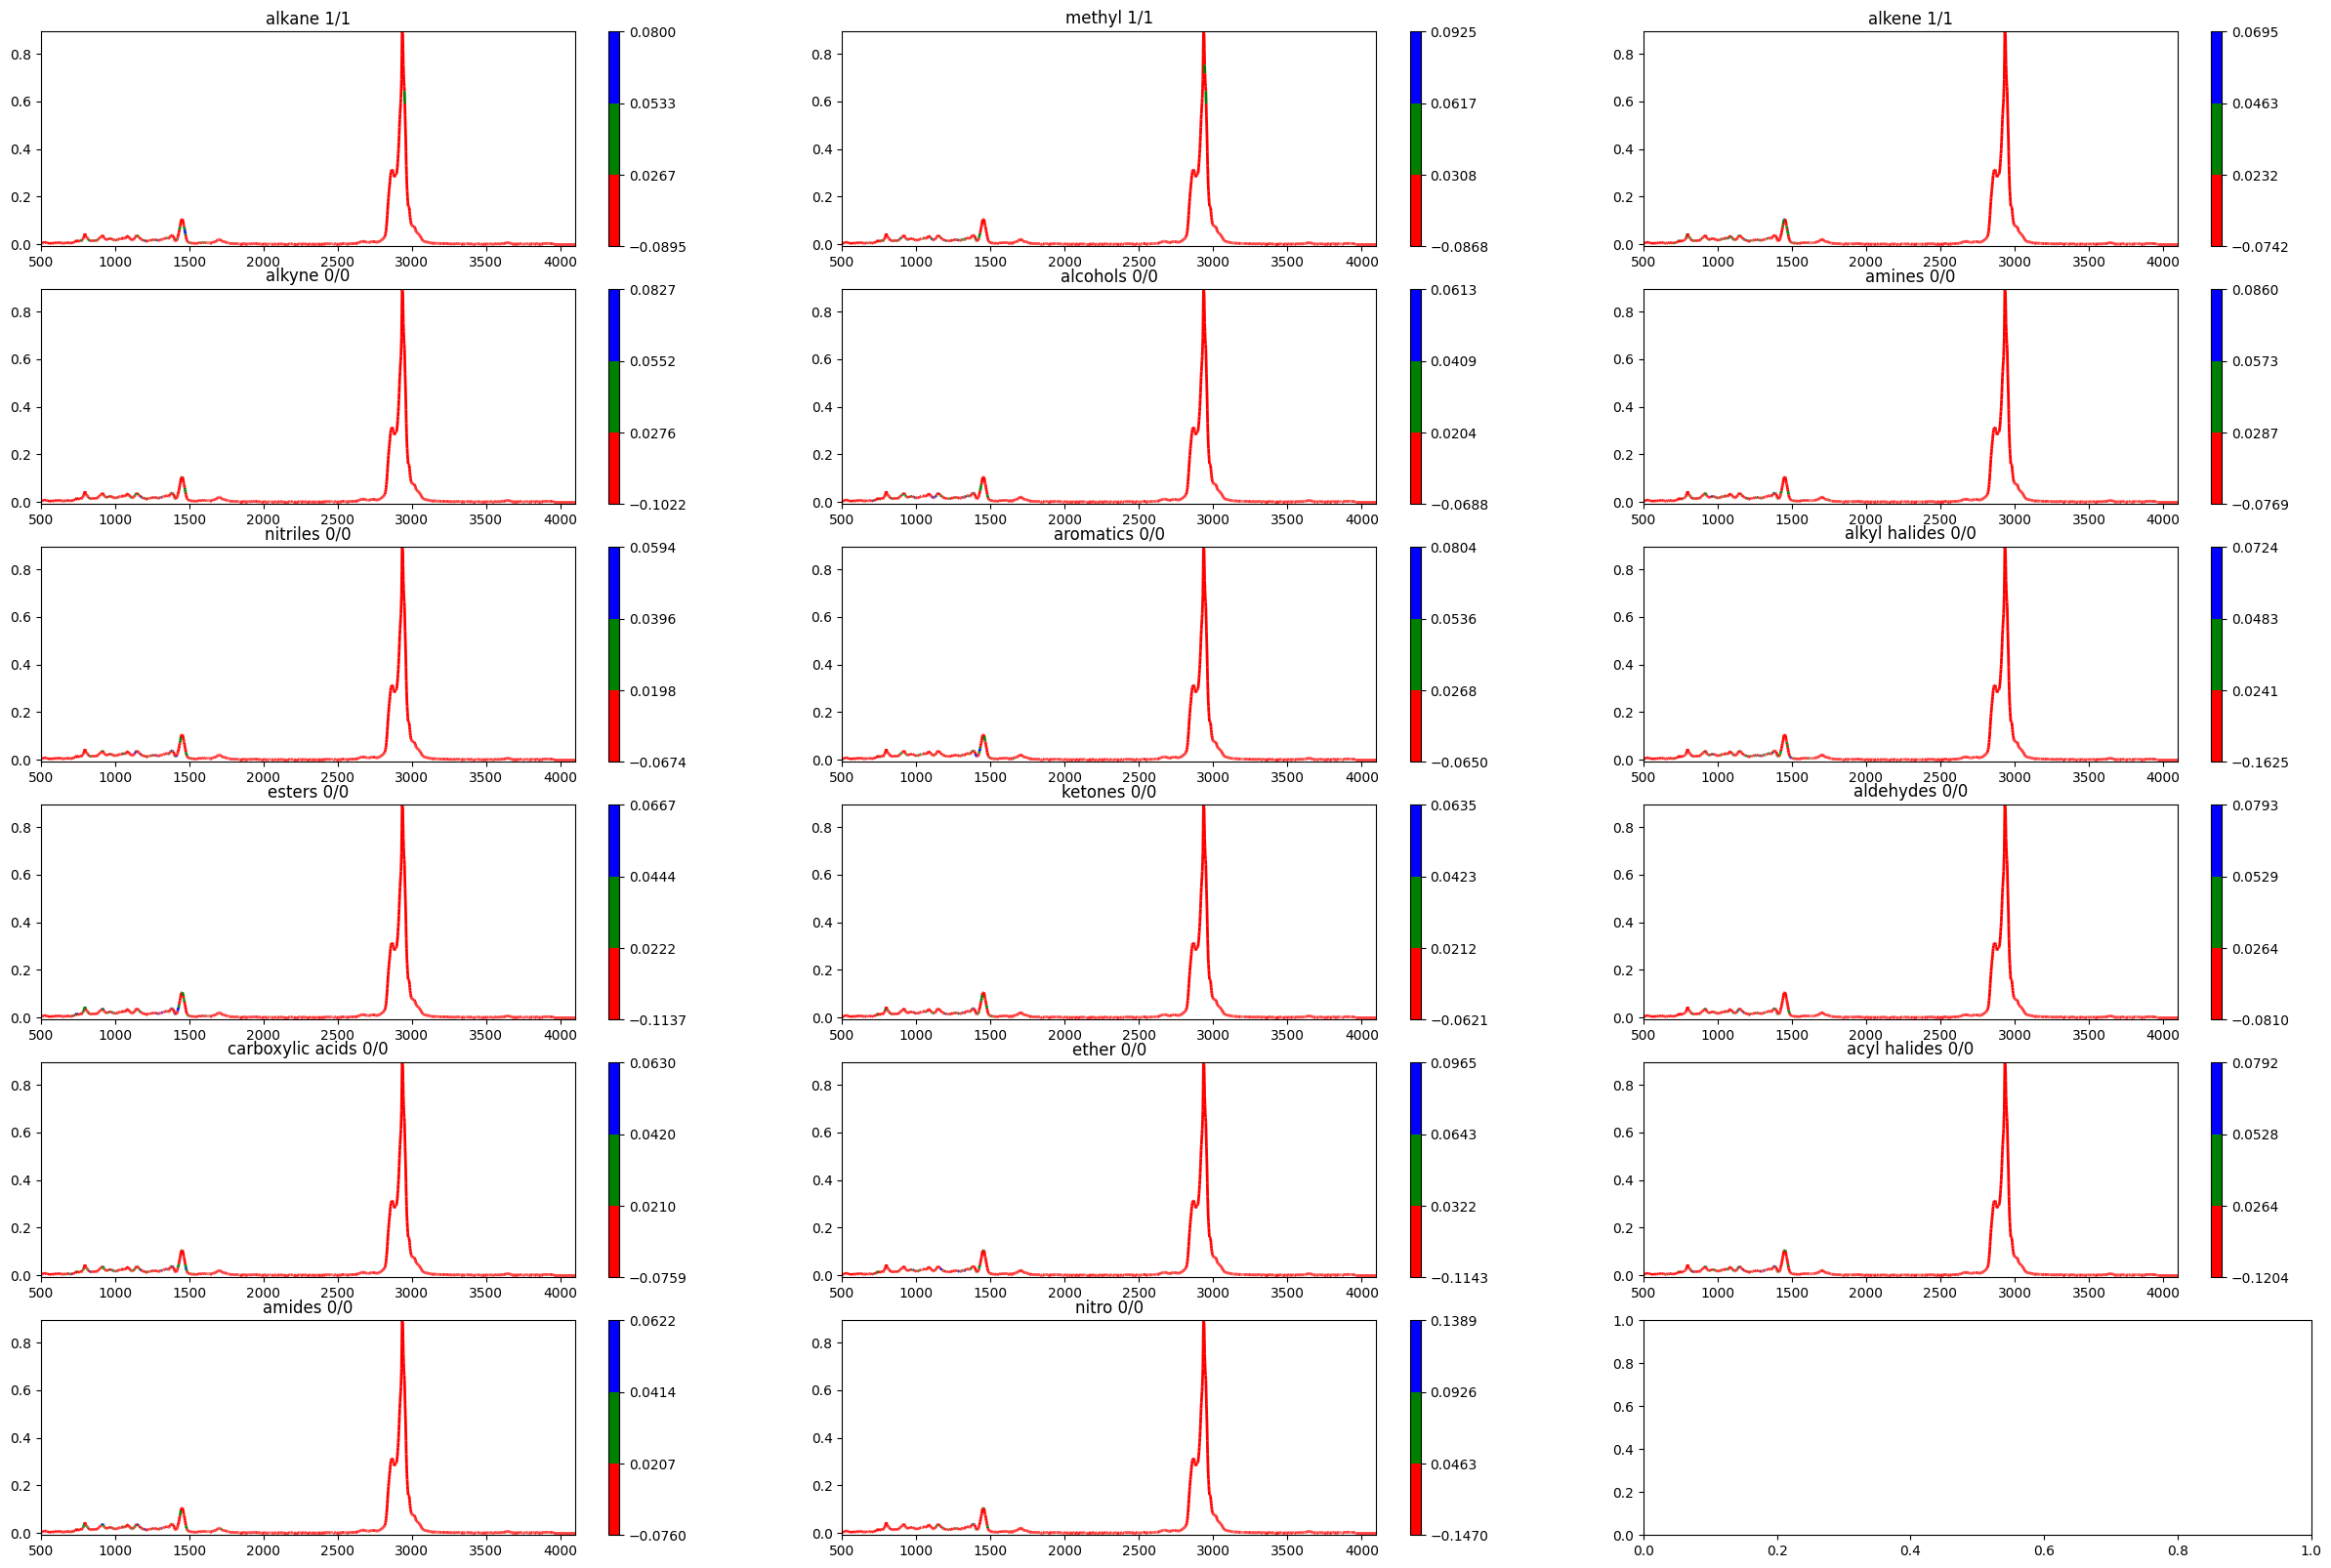

In [102]:
view_all_classes_shap(shap_values, inx2cls, 2,  mode = 'segments')

# Реализация GradCAM

https://colab.research.google.com/drive/1M2f0pHswAKZ-bpp5xhzW8EEOB7J77qla?usp=sharing#scrollTo=Q9h4QmPSa599

In [103]:
!pip install grad-cam
clear_output()

In [104]:
batch = next(iter(dataloader_ir_test))
num = 5
test_specs, test_labels = batch
test_spec = test_specs[num]
test_label = test_labels[num]
test_spec = torch.unsqueeze(test_spec, dim=0)

In [105]:
test_spec.size()

torch.Size([1, 3, 1800])

In [106]:
class ForwardHook():

    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, input_, output): 
        self.activation = output.detach().clone()

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
      self.hook.remove()

In [107]:
with ForwardHook(model._modules['layer7']) as forward_hook:
    output = model.eval()(test_spec)
    activation = forward_hook.activation

print(activation.shape)

torch.Size([1, 400, 56])


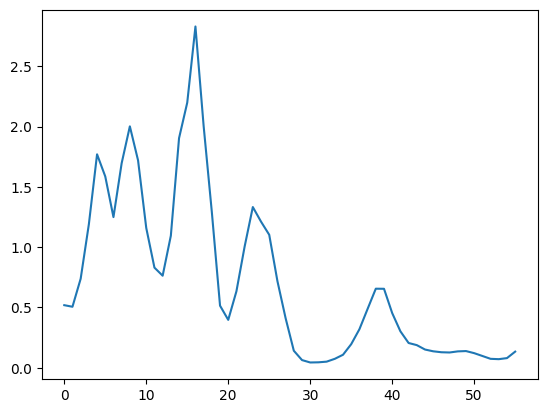

In [108]:
plt.plot(activation[0].T.mean(axis = 1))

In [109]:
import torch.nn.functional as F

number_of_top_classes = 6

prediction = F.softmax(output, dim=1)
top_props, top_inds = prediction.topk(number_of_top_classes)


for i in range(number_of_top_classes):
    category_name = inx2cls[top_inds[0][i].item()]
    score = top_props[0][i].item()
    print(f"{category_name} {top_inds[0][i].item()}: {100 * score:.1f}%")

aromatics 7: 99.3%
alkyl halides 8: 0.5%
methyl 1: 0.2%
amines 5: 0.0%
nitriles 6: 0.0%
alkane 0: 0.0%


In [110]:
class HookBackward():
    def __init__(self, layer):
        self.hook = layer.register_backward_hook(self.hook_func) 

    def hook_func(self, layer, grad_input_, grad_output): 
        self.grad = grad_output[0].detach().clone().mean(dim=[2], keepdim=True)

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [111]:
with HookBackward(model._modules['layer7']) as backward_hook:
        with ForwardHook(model._modules['layer7']) as forward_hook:
            output = model.eval()(test_spec)
            activation = forward_hook.activation
        output[0, top_inds[0][i]].backward()
        weight = backward_hook.grad
        cam_map = F.relu((weight[0] * activation[0]).sum(0)).detach().cpu()
print(output)
print(activation[0][0])
print(weight[0][0])
print((weight[0] * activation[0]).sum(0))

print(cam_map)
print(test_label)

tensor([[ -5.6433,  -1.2724,  -6.6358, -11.8215,  -5.8302,  -3.8300,  -4.3438,
           5.0728,  -0.1964, -14.5799,  -9.6676,  -8.5138, -12.7325,  -8.4887,
         -12.1136,  -8.6413,  -6.7698]], grad_fn=<AddmmBackward0>)
tensor([0.0000, 0.0000, 0.0000, 1.7956, 2.7069, 4.5137, 2.6310, 0.0323, 1.6660,
        0.0000, 0.2127, 3.0857, 2.8270, 1.1092, 2.4715, 7.4041, 9.0857, 0.0000,
        1.6655, 1.5781, 1.5948, 1.8957, 1.8256, 0.6571, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1493, 0.0000, 0.0000,
        0.0159, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3570, 0.6065,
        0.5417, 0.6161, 0.9053, 0.9551, 0.6456, 0.0528, 0.0000, 0.0000, 0.0000,
        0.0000, 0.9052])
tensor([0.0004])
tensor([-1.5625e-02, -1.3465e-02, -1.8207e-02, -4.3590e-02, -7.1390e-02,
        -5.1293e-02, -6.2385e-02, -5.7218e-02, -8.7319e-02, -5.8795e-02,
        -3.1578e-02, -2.2343e-02, -2.3597e-02, -4.2334e-02, -6.7200e-02,
        -9.1657e-02, -8.8824e-02, 

In [112]:
def get_cam_map(model, layer, img, class_num):
    with HookBackward(layer) as backward_hook:
        with ForwardHook(layer) as forward_hook:
            output = model.eval()(img)
            activation = forward_hook.activation
        output[0, class_num].backward()
        weight = backward_hook.grad
        cam_map = F.relu((weight[0] * activation[0]).sum(0)).detach().cpu()
    return cam_map

In [113]:
cam_map = get_cam_map(model, model._modules['layer7'], test_spec,  0)

In [114]:
cam_map.shape

torch.Size([56])

In [115]:
from scipy.interpolate import interp1d
def cam_map_interpolate(cam_map):
  cam_map_x = []
  for i in range(56):
    cam_map_x.append(i*3600/55+500)
  cam_map_x = torch.Tensor(cam_map_x)
  #print(len(cam_map_x))
  f = interp1d(cam_map_x, cam_map)
  cam_map_y = f(cam_map_x)
  return cam_map_y

In [116]:
# plot the feature attributions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def calc_cam_values(model, dataloader, layer, num_test_samples = 1):
  #Создаём тестовый объект
  batch = next(iter(dataloader))
  images, labels = batch
  if len(batch)>(50+num_test_samples):
     background = images[:50]
     test_images = images[50:(50+num_test_samples)]
     test_labels = labels[50:(50+num_test_samples)]
  else: 
    background = images[:(-num_test_samples-1)]
    test_images = images[(-num_test_samples-1):-1]
    test_labels = labels[(-num_test_samples-1):-1]
  model.eval()
  pred = model(test_images).detach().numpy()
  for i in range(len(pred)):
    pred[i][pred[i]>=0.5] = 1
    pred[i][pred[i]<0.5] = 0
  cam_map_all = []
  
  for image in test_images:
    cam_map_image = []
    #print(image.shape)
    image = image.unsqueeze(0)
    #print(image.shape)
    for i in range(17):
      cam_map = get_cam_map(model, layer, image, i)
      cam_map_image.append(cam_map_interpolate(cam_map))
    cam_map_all.append(cam_map_image)
  cam_plus_img = {}
  cam_plus_img['image'] = test_images
  cam_plus_img['cam_map'] = cam_map_all
  cam_plus_img['labels'] = test_labels
  cam_plus_img['pred'] = pred
  clear_output()
  return cam_plus_img

In [117]:
cam_plus_img = calc_cam_values(model, dataloader_ir_test, model._modules['layer7'], num_test_samples = 3)

In [118]:
len(cam_plus_img['cam_map'][0])

17

In [119]:
def plot_cam_continuous(x, y, row_num, col_num, fig, axs, cam_map, title):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= 17:
            dydx = cam_map
            # Create a continuous norm to map from data points to colors
            norm = plt.Normalize(dydx.min(), dydx.max())
            lc = LineCollection(segments, cmap='copper', norm=norm)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min()-0.00001, x.max()+0.000001)
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(20)
            fig.set_figwidth(30)
     
def plot_can_segments(x, y, row_num, col_num, fig, axs, cam_map, title):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= 17:
            dydx = cam_map

            # Use a boundary norm instead
            cmap = ListedColormap(['r', 'g', 'y', 'b'])
            norm = BoundaryNorm([dydx.min()-0.000001, dydx.max()/3+0.0000003, dydx.max()*2/3+0.0000006, dydx.max()+0.000001], cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm)
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            #print(line)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(20)
            fig.set_figwidth(30)

def view_all_classes_cam(cam_plus_img, inx2cls, num = 0,  mode = 'segments'):
  test_spectra = cam_plus_img['image'][num]
  cam_map_all = cam_plus_img['cam_map'][num]
  test_labels = cam_plus_img['labels'][num]
  pred = cam_plus_img['pred'][num]
  x, y = test_spectra[:2]
  x, y = np.array(x), np.array(y)
  
  rows, cols = 6, 3
  fig, axs = plt.subplots(rows, cols, figsize=(5, 10))
  graph_nums = len(cam_map_all)
  if mode == 'continuous':
    for i in range(graph_nums):
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      #print(title)
      plot_cam_continuous(x, y, row, col, fig, axs[row][col], cam_map_all[i], title)
      
   
  elif mode == 'segments':
    for i in range(graph_nums):
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      
      plot_can_segments(x, y, row, col, fig, axs[row][col], cam_map_all[i], title)
      
  
  plt.show()


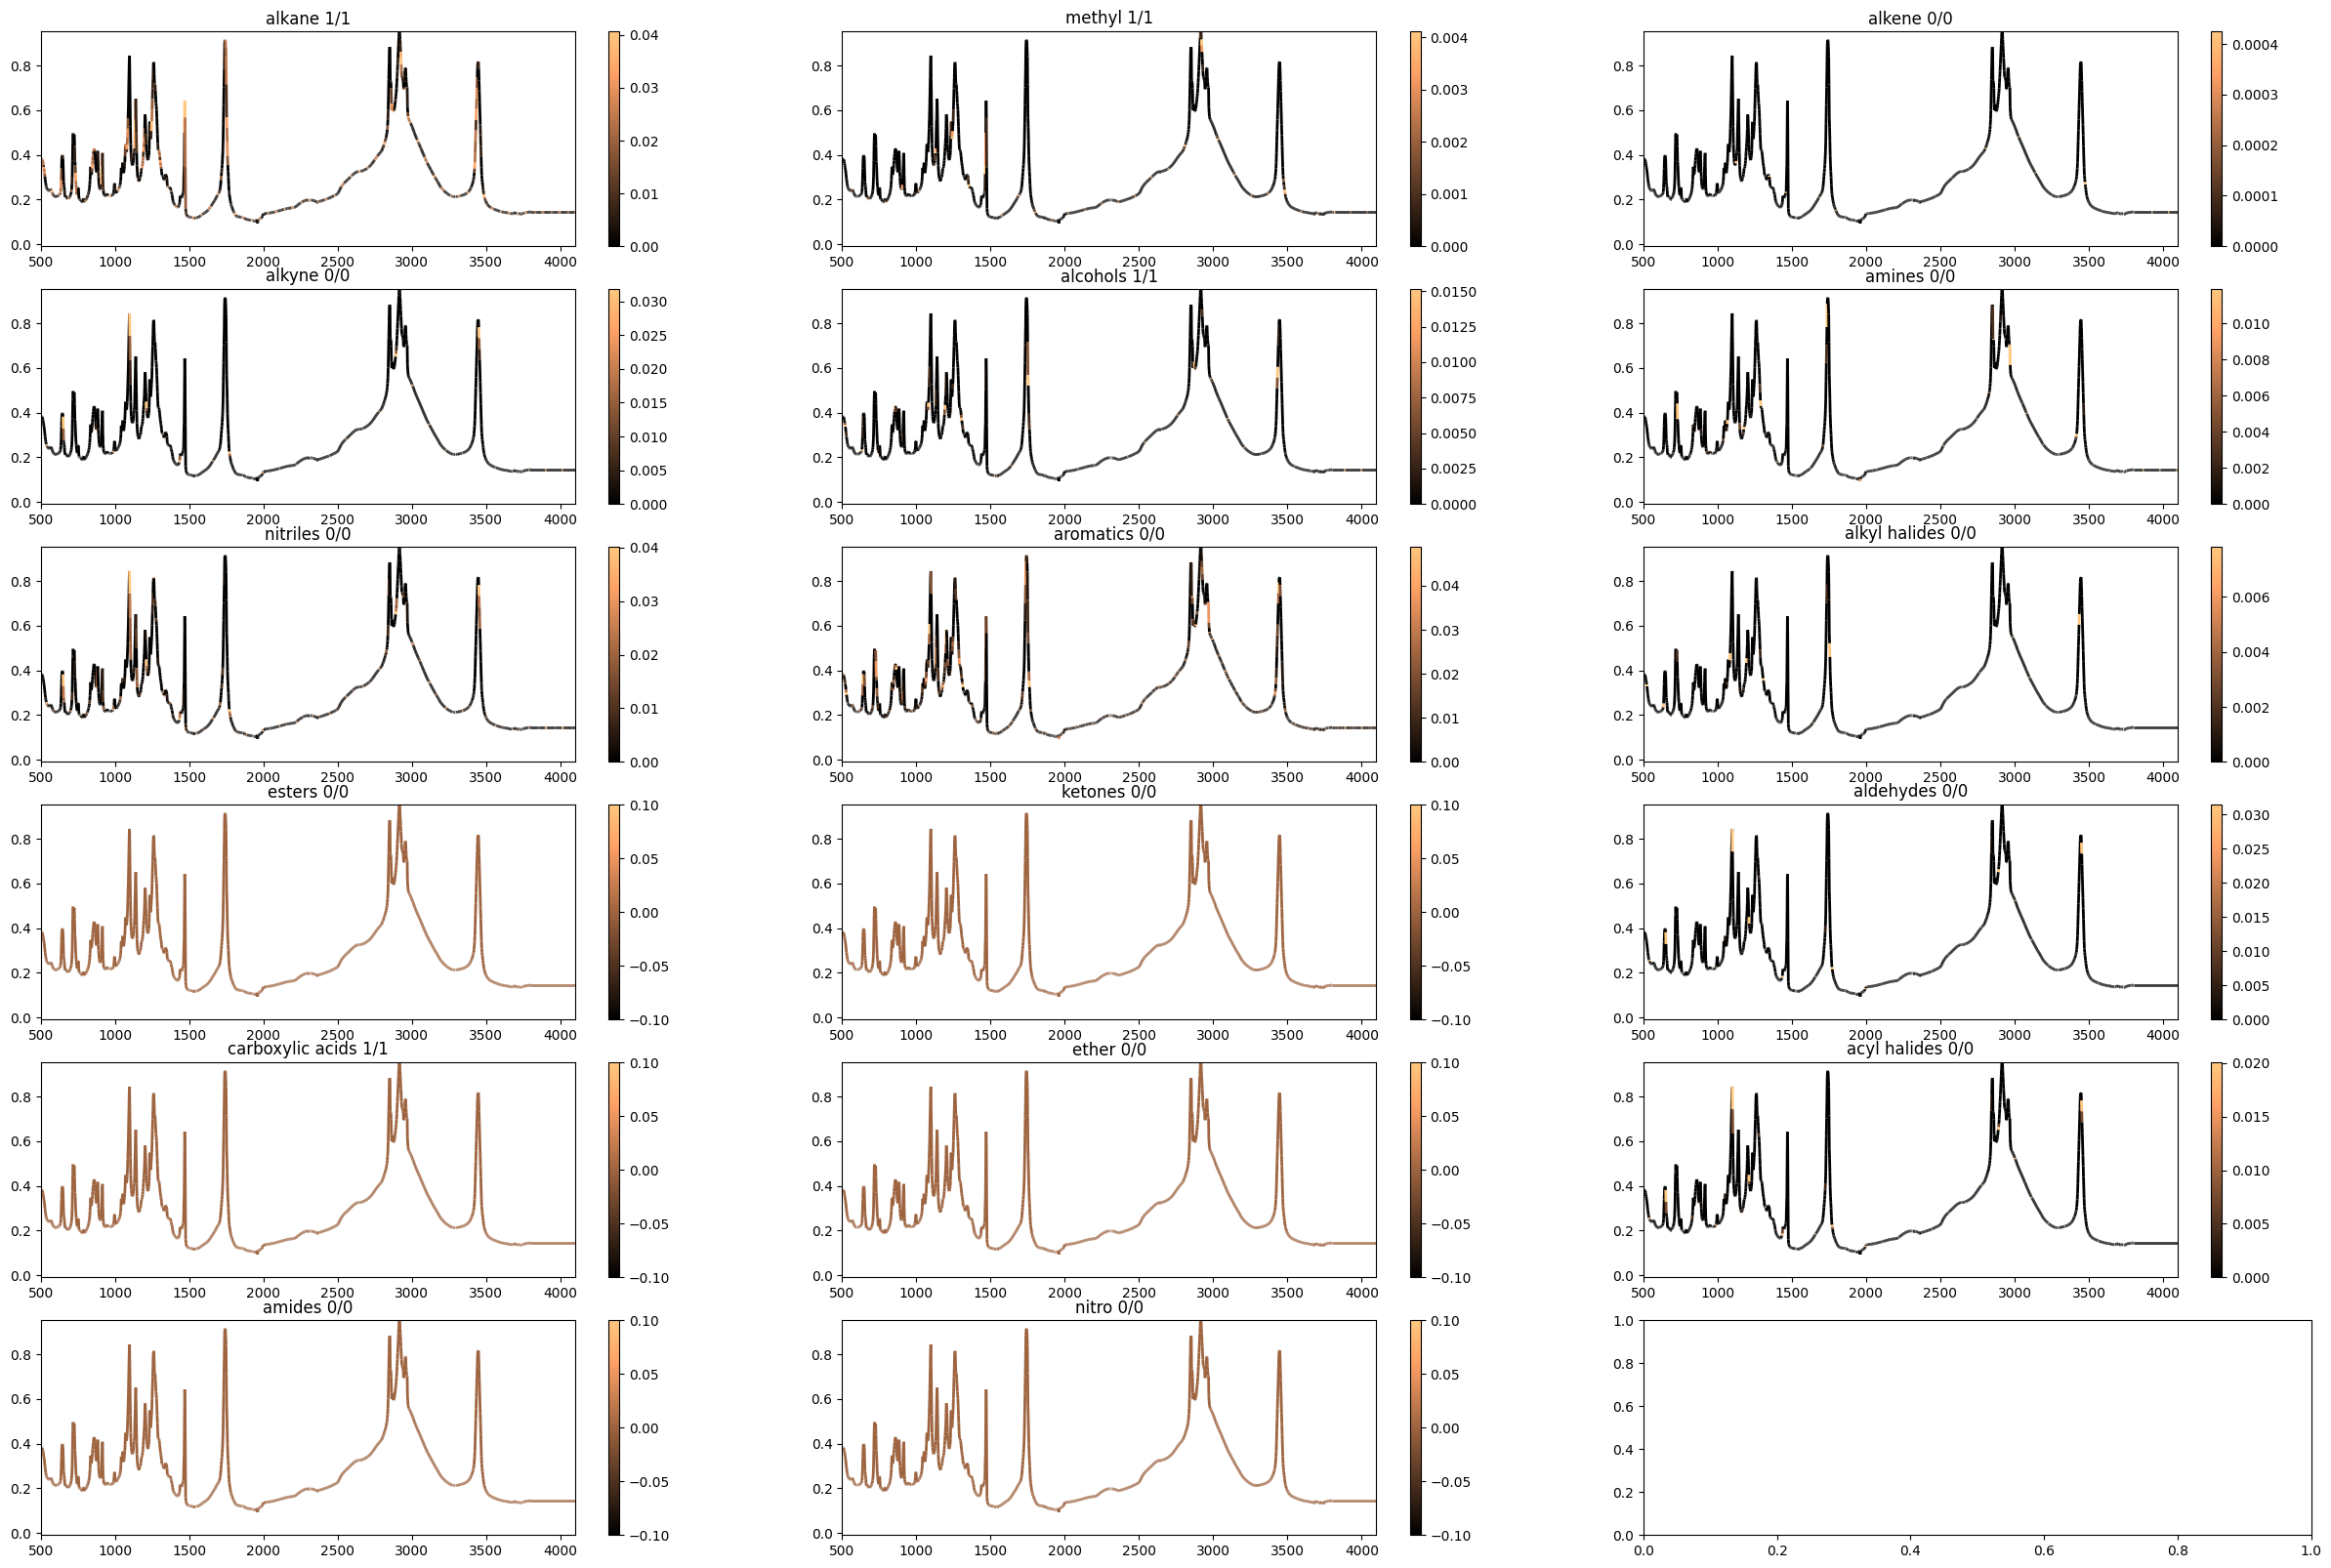

In [120]:
view_all_classes_cam(cam_plus_img, inx2cls, num = 0,  mode = 'continuous')

# Конец